In [3]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from matplotlib import colormaps
from itertools import combinations_with_replacement

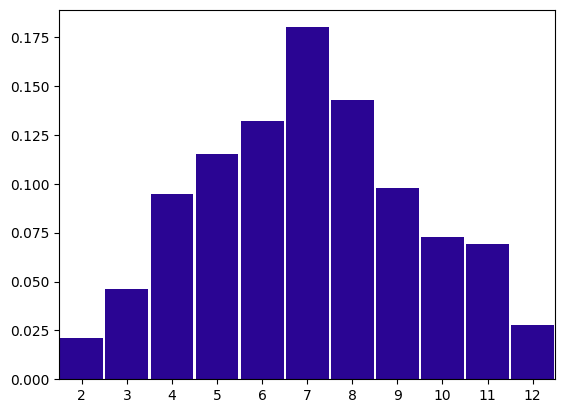

In [11]:
# Set the seed to any value to create a consistent notebook
#rand.seed(12333)

plasma = colormaps['plasma']

# For dice with the following faces,
die_1 = np.array([1, 2, 3, 4, 5, 6])
die_2 = np.array([1, 2, 3, 4, 5, 6])

"""
Rolls each die specified in dice and returns the sum of the faces.
"""
def sum_dice(dice):
  return sum(rand.choice(die) for die in dice)

N = 1000
results = np.zeros((N, 1))

# Roll the dice N times and store the sums
for i in range(N):
  results[i] = sum_dice([die_1, die_2])


fig, ax = plt.subplots()

# Visualize the sum as a bar chart
buffer = 1 / 2
vals, frq = np.unique(results, return_counts=True)
ax.bar(vals, frq / np.sum(frq), width=0.95, color=plasma(0.05))
ax.set_xlim(np.min(vals) - buffer, np.max(vals) + buffer)
ax.set_xticks(range(np.min(vals.astype(int)), np.max(vals.astype(int))+1))
pass

We can see that with a naive experiment (perhaps using too few samples as above, try rerunning the cell for increasing ```N``` until you obtain consistent result), it may be difficult to use the experimental distribution to compare sets of dice.

Consider the sum of the Cartesian product (which I will call the Cartesian sum) has an interesting property for 2 dice (below I give examples for 2 six sided die, then 2 8 sided die).

In [5]:
"""
The sum of the Cartesian product for the set of dice.
Enumerates all of the possible sums of the dice and returns
them in a consistent order.
"""
def cartesian_sum(dice):
  return np.sum(np.dstack(np.meshgrid(*dice)).reshape(-1, len(dice)), axis=1)

# For dice with the following side numbers
# Assuming standard dice (a 4 sided die has faces [1,2,3,4], etc.)
for i in 4, 6, 8:
  print(cartesian_sum(2*[range(1, i+1)]).reshape(i, i))

[[2 3 4 5]
 [3 4 5 6]
 [4 5 6 7]
 [5 6 7 8]]
[[ 2  3  4  5  6  7]
 [ 3  4  5  6  7  8]
 [ 4  5  6  7  8  9]
 [ 5  6  7  8  9 10]
 [ 6  7  8  9 10 11]
 [ 7  8  9 10 11 12]]
[[ 2  3  4  5  6  7  8  9]
 [ 3  4  5  6  7  8  9 10]
 [ 4  5  6  7  8  9 10 11]
 [ 5  6  7  8  9 10 11 12]
 [ 6  7  8  9 10 11 12 13]
 [ 7  8  9 10 11 12 13 14]
 [ 8  9 10 11 12 13 14 15]
 [ 9 10 11 12 13 14 15 16]]


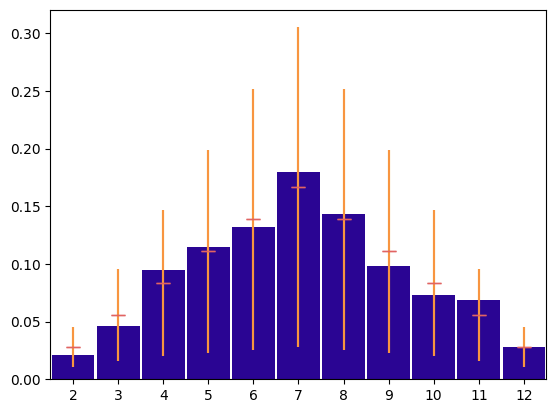

In [13]:
# The expected distribution is outlined in red
# TODO: Some measure of the variance outlined in orange
# Since it follows a multinomial distribution (explain)
# (it must since we can enumerate all of equiprobable outcomes)

# The form of the variance for the multinomial is
# Var(X_i) = n p_i(1 - p_i)
# n is the number of trials
# p_i is the probablitity of the ith sum
n = 6
target = np.sort(cartesian_sum(2*[range(1, n+1)]))
vals, frq = np.unique(target, return_counts=True)
p_i = frq / np.power(n, 2)
std = np.sqrt(vals.shape[0] * p_i * (1 - p_i))

# Wald confidence for binomials
# I guess we are treating everything independently here.
# https://stackoverflow.com/questions/10029588/python-implementation-of-the-wilson-score-interval
def confidence(phat, z):
  #z = 1.96 #1.44 = 85%, 1.96 = 95%
  return ((phat + z*z/(2*N) - z * np.sqrt((phat*(1-phat)+z*z/(4*N))/N))/(1+z*z/N))

ax.errorbar(x=vals,
            y=frq / np.sum(frq),
            yerr=confidence(p_i, 2.576),
            marker='_',
            linestyle='',
            markersize=10,
            markeredgecolor=plasma(0.6),
            markerfacecolor=plasma(0.6),
            c=plasma(0.75)
            )
fig

Notice the beautiful symmetry. For 2 identical dice with $n$ sides, the sum of their outcomes follows a simple tabular pattern: one 2, two 3s, three 4s, ..., $n$ lots of $n+1$, then decreasing again! Or as a generalized table,

| sum             | 2 | 3 | 4 | 5 | $\cdots$ | $n + 1$ | $n + 2$ | $\cdots$ | $2n$ |
| ---             |---|---|---|---| ---      | ---     | ---     | ---      | ---  |
| representations | 1 | 2 | 3 | 4 | $\cdots$ | $n$     | $n - 1$ | $\cdots$ | 1    |

For two dice with $n$ sides each labelled $x_{jl}$, with $j = 1, 2, \cdots n$ (WLOG assume $x_{jl}$ to be ordered in $j$) and $l = 1, 2$ specifying the identity of the die (as we allow each dice to have different faces), a solution satisfies the following system of $i$ equalities:

$$\#\{(k,\, m)\; |\; x_{k1} + x_{m2} = 2\} = 1$$

$$\#\{(k,\, m)\; |\; x_{k1} + x_{m2} = 3\} = 2$$

$$\vdots$$

$$\#\{(k,\, m)\; |\; x_{k1} + x_{m2} = n + 1\} = n$$

$$\vdots$$

$$\#\{(k,\, m)\; |\; x_{k1} + x_{m2} = 2n\} = 1$$

following the table above, where the notation $\#\{\}$ is used to mean the number of elements (in this case, pairs $(k,\, m)$) in the set. This means in order to do a brute force search, identifying identical distribution is equivalent to ensuring the ordered sum's number of representations is exactly equal to that of the equal, unaltered dice. The pattern becomes, in more formal notation for each $i$:

$$\#\{(k,\, m)\; |\; x_{j1} + x_{k2} = 2i\} = r_i$$

where
$$
r_i =
\begin{cases}
i & \text{ if } i \leq n\\
n - i & \text{ otherwise }
\end{cases}
$$

In other words, for the count of sums below,

$$
s_{i}(x_{j1}, x_{j2}) =
\sum_{k=1}^n \sum_{m=1}^n \mathbf{1}_{x_{k1} + x_{m2} = 2i}
$$

we require $s_i ≡ r_i$, where $\mathbf{1}$ is the indicator function. This is the same system of equalities in $i$, and we should clarify the solution space. The $x_{jl}$ should be positive integers, and clearly will not exceed $2n-1$. Another important fact for reducing the search space is that $x_{1l} \equiv 1$, since we need to be able to roll the minimum.

In [33]:
# A naive, brute force approach:
def dice_space(n=6):
  space = combinations_with_replacement(range(1, 2*n-1), n-1)
  for faces in space:
    yield (1, *faces)

def grid_search_dice(n):
  target = np.sort(cartesian_sum(2*[range(1, n+1)]))
  dice_space_1 = dice_space(n)

  for die_1 in dice_space_1:
    dice_space_2 = dice_space(n)
    for die_2 in dice_space_2:
      distribution = np.sort(np.ravel(cartesian_sum([die_1, die_2])))
      if np.all(distribution == target):
        print(f'{die_1} and {die_2} have the desired properties.')

grid_search_dice(6)


(1, 2, 2, 3, 3, 4) and (1, 3, 4, 5, 6, 8) have the desired properties.
(1, 2, 3, 4, 5, 6) and (1, 2, 3, 4, 5, 6) have the desired properties.
(1, 3, 4, 5, 6, 8) and (1, 2, 2, 3, 3, 4) have the desired properties.


In [ ]:
grid_search_dice(8)

More generally, the counts can be generated in the following way: for $l = 1,\cdots, N$ dice each with $n_l$ sides each with faces $x_{jl}$: